
✓ Imagen 'torre_eiffel.jpg' cargada exitosamente

Dimensiones de la imagen: (256, 256)
Nivel de ruido (σ): 0.1

--------------------------------------------------------------------------------
PASO 1: Aplicando Métodos Tradicionales
--------------------------------------------------------------------------------

✓ Filtro Pasa Bajos:
  PSNR: 22.30 dB | SSIM: 0.7296 | MSE: 0.005892

✓ Filtro Mediana:
  PSNR: 23.53 dB | SSIM: 0.7013 | MSE: 0.004432

--------------------------------------------------------------------------------
PASO 2: Creando y Entrenando Redes Neuronales
--------------------------------------------------------------------------------

Generando dataset de entrenamiento (500 patches de 64x64)...
   Dataset generado: 500 patches

Creando arquitecturas...


Entrenando DnCNN...
✓ DnCNN entrenado - Loss final: 0.003228


Entrenando UNet...
✓ U-Net entrenado - Loss final: 0.002051


Entrenando Autoencoder...
✓ Autoencoder entrenado - Loss final: 0.002025

-----------------

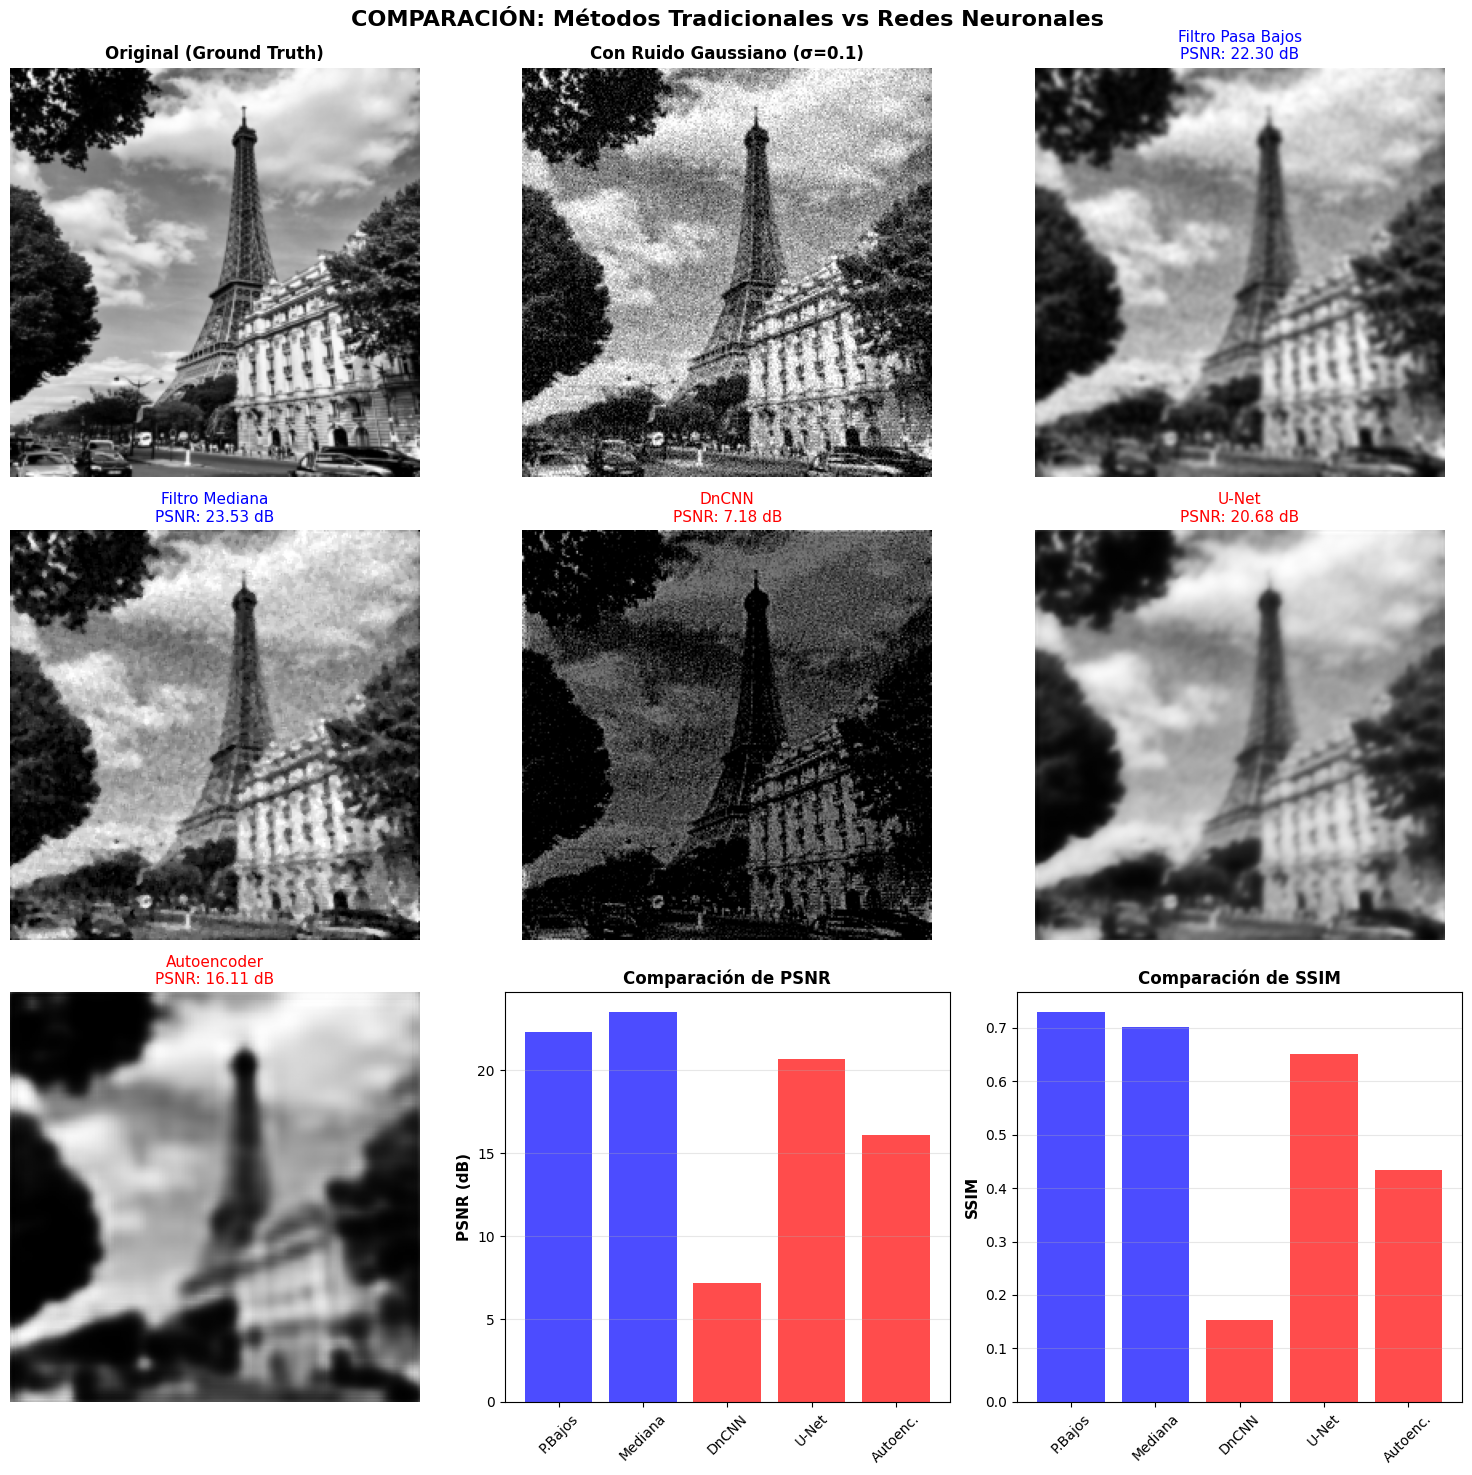

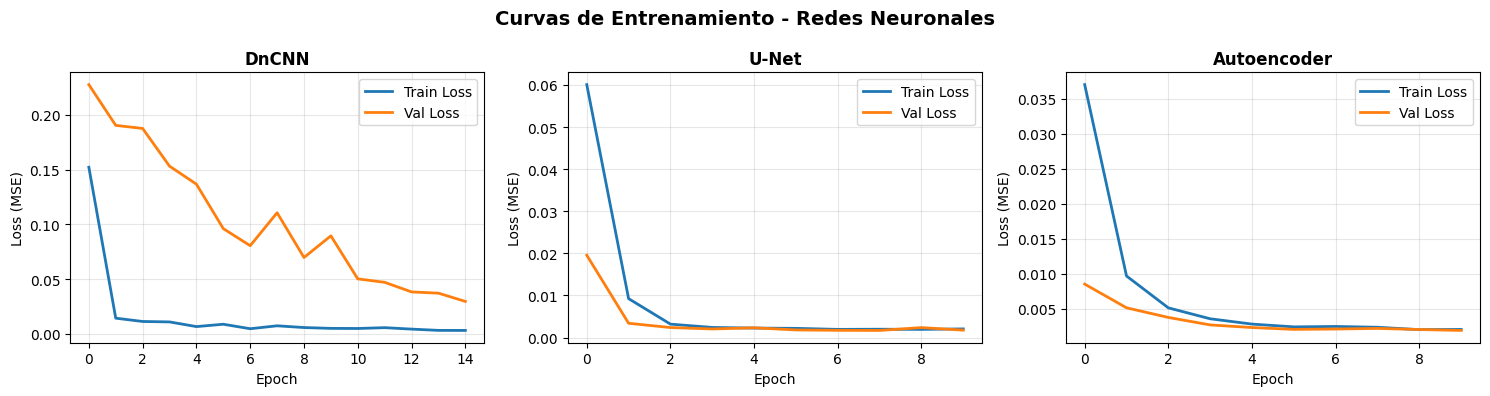

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import medfilt2d
from skimage import io, color, util
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.filters import gaussian
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. FUNCIONES PARA AGREGAR RUIDO
# ============================================================================

def agregar_ruido_gaussiano(imagen, sigma=0.1):
    """Agrega ruido gaussiano a una imagen"""
    ruido = np.random.normal(0, sigma, imagen.shape)
    imagen_ruidosa = imagen + ruido
    return np.clip(imagen_ruidosa, 0, 1)

def agregar_ruido_salt_pepper(imagen, cantidad=0.05):
    """Agrega ruido salt & pepper (impulsivo)"""
    imagen_ruidosa = imagen.copy()
    num_salt = np.ceil(cantidad * imagen.size * 0.5)
    coords = [np.random.randint(0, i, int(num_salt)) for i in imagen.shape]
    imagen_ruidosa[coords[0], coords[1]] = 1
    
    num_pepper = np.ceil(cantidad * imagen.size * 0.5)
    coords = [np.random.randint(0, i, int(num_pepper)) for i in imagen.shape]
    imagen_ruidosa[coords[0], coords[1]] = 0
    
    return imagen_ruidosa

# ============================================================================
# 2. MÉTODOS TRADICIONALES
# ============================================================================

def filtro_pasa_bajos(imagen, sigma=1):
    """Filtro pasa bajos (Gaussiano)"""
    return gaussian(imagen, sigma=sigma)

def filtro_mediana(imagen, size=3):
    """Filtro de mediana"""
    return medfilt2d(imagen, kernel_size=size)

# ============================================================================
# 3. ARQUITECTURAS DE REDES NEURONALES
# ============================================================================

def crear_dncnn(profundidad=17):
    """
    DnCNN - Denoising Convolutional Neural Network
    Aprende a predecir el ruido y restarlo de la imagen
    """
    model = models.Sequential(name='DnCNN')
    
    # Primera capa: Conv + ReLU
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                           input_shape=(None, None, 1)))
    
    # Capas intermedias: Conv + BatchNorm + ReLU
    for _ in range(profundidad - 2):
        model.add(layers.Conv2D(64, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
    
    # Última capa: predice el ruido
    model.add(layers.Conv2D(1, (3, 3), padding='same'))
    
    return model

def crear_unet(input_size=(256, 256, 1)):
    """
    U-Net - Arquitectura encoder-decoder con skip connections
    Común en restauración de imágenes
    """
    inputs = layers.Input(input_size)
    
    # Encoder (contracción)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder (expansión) con skip connections
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    # Salida
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    return models.Model(inputs=[inputs], outputs=[outputs], name='UNet')

def crear_autoencoder(input_size=(256, 256, 1)):
    """
    Autoencoder - Aprende representación comprimida para reconstruir sin ruido
    """
    inputs = layers.Input(input_size)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    return models.Model(inputs, decoded, name='Autoencoder')

# ============================================================================
# 4. MÉTRICAS DE EVALUACIÓN
# ============================================================================

def calcular_metricas(imagen_original, imagen_procesada):
    """Calcula PSNR, SSIM y MSE"""
    psnr = peak_signal_noise_ratio(imagen_original, imagen_procesada, data_range=1.0)
    ssim = structural_similarity(imagen_original, imagen_procesada, data_range=1.0)
    mse = np.mean((imagen_original - imagen_procesada) ** 2)
    
    return {'PSNR': psnr, 'SSIM': ssim, 'MSE': mse}

# ============================================================================
# 5. ENTRENAMIENTO DE MODELOS
# ============================================================================

def generar_dataset_entrenamiento(imagen_limpia, num_patches=500, patch_size=64, sigma=0.1):
    """Genera patches para entrenamiento"""
    h, w = imagen_limpia.shape
    patches_limpios = []
    patches_ruidosos = []
    
    for _ in range(num_patches):
        # Extraer patch aleatorio
        i = np.random.randint(0, h - patch_size)
        j = np.random.randint(0, w - patch_size)
        
        patch_limpio = imagen_limpia[i:i+patch_size, j:j+patch_size]
        patch_ruidoso = agregar_ruido_gaussiano(patch_limpio, sigma=sigma)
        
        patches_limpios.append(patch_limpio)
        patches_ruidosos.append(patch_ruidoso)
    
    return np.array(patches_ruidosos), np.array(patches_limpios)

def entrenar_modelo(modelo, X_train, y_train, epochs=20, batch_size=16):
    """Entrena un modelo de denoising"""
    # Reshape para TensorFlow
    X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
    y_train = y_train.reshape(-1, y_train.shape[1], y_train.shape[2], 1)
    
    # Compilar modelo
    modelo.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Entrenar
    print(f"\nEntrenando {modelo.name}...")
    history = modelo.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0
    )
    
    return history

def predecir_imagen_completa(modelo, imagen, nombre_modelo):
    """Aplica modelo entrenado a imagen completa"""
    # Para DnCNN: predice ruido y lo resta
    if nombre_modelo == "DnCNN":
        imagen_input = imagen.reshape(1, imagen.shape[0], imagen.shape[1], 1)
        ruido_predicho = modelo.predict(imagen_input, verbose=0)
        resultado = imagen - ruido_predicho[0, :, :, 0]
        return np.clip(resultado, 0, 1)
    
    # Para UNet y Autoencoder: predicen imagen limpia directamente
    else:
        # Redimensionar si es necesario
        original_shape = imagen.shape
        if imagen.shape != (256, 256):
            imagen_resized = resize(imagen, (256, 256), anti_aliasing=True)
        else:
            imagen_resized = imagen
        
        imagen_input = imagen_resized.reshape(1, 256, 256, 1)
        resultado = modelo.predict(imagen_input, verbose=0)
        resultado = resultado[0, :, :, 0]
        
        # Volver al tamaño original
        if original_shape != (256, 256):
            resultado = resize(resultado, original_shape, anti_aliasing=True)
        
        return np.clip(resultado, 0, 1)

# ============================================================================
# 6. FUNCIÓN PRINCIPAL DE COMPARACIÓN
# ============================================================================

def comparar_todos_metodos():
    """Compara métodos tradicionales vs redes neuronales"""
    
    # Cargar o crear imagen
    try:
        imagen = io.imread('torre_eiffel.jpg')
        if len(imagen.shape) == 3:
            imagen = color.rgb2gray(imagen)
        print("\n✓ Imagen 'torre_eiffel.jpg' cargada exitosamente")
    except:
        print("\n⚠ No se encontró 'torre_eiffel.jpg'. Creando imagen sintética...")
        x, y = np.meshgrid(np.linspace(-2, 2, 256), np.linspace(-2, 2, 256))
        imagen = np.exp(-(x**2 + y**2)) * 0.8 + 0.2
        # Agregar algunos detalles
        imagen += 0.3 * np.sin(10*x) * np.sin(10*y)
    
    # Normalizar y redimensionar para consistencia
    imagen = imagen.astype(float) / imagen.max()
    if imagen.shape[0] > 512 or imagen.shape[1] > 512:
        imagen = resize(imagen, (256, 256), anti_aliasing=True)
    
    # Agregar ruido gaussiano
    sigma = 0.1
    imagen_ruidosa = agregar_ruido_gaussiano(imagen, sigma=sigma)
    
    print(f"\nDimensiones de la imagen: {imagen.shape}")
    print(f"Nivel de ruido (σ): {sigma}")
    
    # ========================================================================
    # PASO 1: MÉTODOS TRADICIONALES
    # ========================================================================
    print("\n" + "-"*80)
    print("PASO 1: Aplicando Métodos Tradicionales")
    print("-"*80)
    
    resultado_pb = filtro_pasa_bajos(imagen_ruidosa, sigma=1.5)
    resultado_med = filtro_mediana(imagen_ruidosa, size=3)
    
    metricas_pb = calcular_metricas(imagen, resultado_pb)
    metricas_med = calcular_metricas(imagen, resultado_med)
    
    print("\n✓ Filtro Pasa Bajos:")
    print(f"  PSNR: {metricas_pb['PSNR']:.2f} dB | SSIM: {metricas_pb['SSIM']:.4f} | MSE: {metricas_pb['MSE']:.6f}")
    
    print("\n✓ Filtro Mediana:")
    print(f"  PSNR: {metricas_med['PSNR']:.2f} dB | SSIM: {metricas_med['SSIM']:.4f} | MSE: {metricas_med['MSE']:.6f}")
    
    # ========================================================================
    # PASO 2: CREAR Y ENTRENAR REDES NEURONALES
    # ========================================================================
    print("\n" + "-"*80)
    print("PASO 2: Creando y Entrenando Redes Neuronales")
    print("-"*80)
    
    # Generar dataset de entrenamiento
    print("\nGenerando dataset de entrenamiento (500 patches de 64x64)...")
    X_train, y_train = generar_dataset_entrenamiento(imagen, num_patches=500, 
                                                      patch_size=64, sigma=sigma)
    print(f"   Dataset generado: {X_train.shape[0]} patches")
    
    # Crear modelos
    print("\nCreando arquitecturas...")
    dncnn = crear_dncnn(profundidad=10)  # Más ligero para demo
    unet = crear_unet(input_size=(256, 256, 1))
    autoencoder = crear_autoencoder(input_size=(256, 256, 1))
    
    # Entrenar DnCNN
    print("\n" + "="*80)
    history_dncnn = entrenar_modelo(dncnn, X_train, X_train, epochs=15, batch_size=16)
    print(f"✓ DnCNN entrenado - Loss final: {history_dncnn.history['loss'][-1]:.6f}")
    
    # Entrenar UNet  
    print("\n" + "="*80)
    # Para UNet, usar patches más grandes
    X_train_unet = np.array([resize(p, (256, 256)) for p in X_train[:100]])
    y_train_unet = np.array([resize(p, (256, 256)) for p in y_train[:100]])
    history_unet = entrenar_modelo(unet, X_train_unet, y_train_unet, epochs=10, batch_size=4)
    print(f"✓ U-Net entrenado - Loss final: {history_unet.history['loss'][-1]:.6f}")
    
    # Entrenar Autoencoder
    print("\n" + "="*80)
    history_ae = entrenar_modelo(autoencoder, X_train_unet, y_train_unet, epochs=10, batch_size=4)
    print(f"✓ Autoencoder entrenado - Loss final: {history_ae.history['loss'][-1]:.6f}")
    
    # ========================================================================
    # PASO 3: APLICAR REDES NEURONALES A IMAGEN COMPLETA
    # ========================================================================
    print("\n" + "-"*80)
    print("PASO 3: Aplicando Redes Neuronales a Imagen Completa")
    print("-"*80)
    
    resultado_dncnn = predecir_imagen_completa(dncnn, imagen_ruidosa, "DnCNN")
    resultado_unet = predecir_imagen_completa(unet, imagen_ruidosa, "UNet")
    resultado_ae = predecir_imagen_completa(autoencoder, imagen_ruidosa, "Autoencoder")
    
    metricas_dncnn = calcular_metricas(imagen, resultado_dncnn)
    metricas_unet = calcular_metricas(imagen, resultado_unet)
    metricas_ae = calcular_metricas(imagen, resultado_ae)
    
    print("\nDnCNN:")
    print(f"  PSNR: {metricas_dncnn['PSNR']:.2f} dB | SSIM: {metricas_dncnn['SSIM']:.4f} | MSE: {metricas_dncnn['MSE']:.6f}")
    
    print("\nU-Net:")
    print(f"  PSNR: {metricas_unet['PSNR']:.2f} dB | SSIM: {metricas_unet['SSIM']:.4f} | MSE: {metricas_unet['MSE']:.6f}")
    
    print("\nAutoencoder:")
    print(f"  PSNR: {metricas_ae['PSNR']:.2f} dB | SSIM: {metricas_ae['SSIM']:.4f} | MSE: {metricas_ae['MSE']:.6f}")
    
    # ========================================================================
    # VISUALIZACIÓN COMPARATIVA
    # ========================================================================
    print("\n" + "-"*80)
    print("PASO 4: Generando Visualizaciones")
    print("-"*80)
    
    # Figura 1: Comparación completa
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('COMPARACIÓN: Métodos Tradicionales vs Redes Neuronales', 
                 fontsize=16, fontweight='bold')
    
    # Fila 1: Original, Ruidosa, Filtro Pasa Bajos
    axes[0, 0].imshow(imagen, cmap='gray')
    axes[0, 0].set_title('Original (Ground Truth)', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(imagen_ruidosa, cmap='gray')
    axes[0, 1].set_title(f'Con Ruido Gaussiano (σ={sigma})', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(resultado_pb, cmap='gray')
    axes[0, 2].set_title(f'Filtro Pasa Bajos\nPSNR: {metricas_pb["PSNR"]:.2f} dB', 
                        fontsize=11, color='blue')
    axes[0, 2].axis('off')
    
    # Fila 2: Filtro Mediana, DnCNN, U-Net
    axes[1, 0].imshow(resultado_med, cmap='gray')
    axes[1, 0].set_title(f'Filtro Mediana\nPSNR: {metricas_med["PSNR"]:.2f} dB', 
                        fontsize=11, color='blue')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(resultado_dncnn, cmap='gray')
    axes[1, 1].set_title(f'DnCNN\nPSNR: {metricas_dncnn["PSNR"]:.2f} dB', 
                        fontsize=11, color='red')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(resultado_unet, cmap='gray')
    axes[1, 2].set_title(f'U-Net\nPSNR: {metricas_unet["PSNR"]:.2f} dB', 
                        fontsize=11, color='red')
    axes[1, 2].axis('off')
    
    # Fila 3: Autoencoder y métricas
    axes[2, 0].imshow(resultado_ae, cmap='gray')
    axes[2, 0].set_title(f'Autoencoder\nPSNR: {metricas_ae["PSNR"]:.2f} dB', 
                        fontsize=11, color='red')
    axes[2, 0].axis('off')
    
    # Gráfico de comparación de PSNR
    metodos = ['P.Bajos', 'Mediana', 'DnCNN', 'U-Net', 'Autoenc.']
    psnrs = [metricas_pb['PSNR'], metricas_med['PSNR'], metricas_dncnn['PSNR'], 
             metricas_unet['PSNR'], metricas_ae['PSNR']]
    colores = ['blue', 'blue', 'red', 'red', 'red']
    
    axes[2, 1].bar(metodos, psnrs, color=colores, alpha=0.7)
    axes[2, 1].set_ylabel('PSNR (dB)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Comparación de PSNR', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    axes[2, 1].tick_params(axis='x', rotation=45)
    
    # Gráfico de comparación de SSIM
    ssims = [metricas_pb['SSIM'], metricas_med['SSIM'], metricas_dncnn['SSIM'], 
             metricas_unet['SSIM'], metricas_ae['SSIM']]
    
    axes[2, 2].bar(metodos, ssims, color=colores, alpha=0.7)
    axes[2, 2].set_ylabel('SSIM', fontsize=11, fontweight='bold')
    axes[2, 2].set_title('Comparación de SSIM', fontsize=12, fontweight='bold')
    axes[2, 2].grid(axis='y', alpha=0.3)
    axes[2, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('comparacion_completa.png', dpi=150, bbox_inches='tight')
    print("Figura guardada: comparacion_completa.png")
    
    # Figura 2: Curvas de entrenamiento
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Curvas de Entrenamiento - Redes Neuronales', 
                 fontsize=14, fontweight='bold')
    
    axes[0].plot(history_dncnn.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history_dncnn.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title('DnCNN', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(history_unet.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history_unet.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title('U-Net', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss (MSE)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    axes[2].plot(history_ae.history['loss'], label='Train Loss', linewidth=2)
    axes[2].plot(history_ae.history['val_loss'], label='Val Loss', linewidth=2)
    axes[2].set_title('Autoencoder', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss (MSE)')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('curvas_entrenamiento.png', dpi=150, bbox_inches='tight')
    print("Figura guardada: curvas_entrenamiento.png")
    
    # ========================================================================
    # RESUMEN FINAL
    # ========================================================================
    print("\n" + "="*80)
    print("RESUMEN DE RESULTADOS")
    print("="*80)
    
    # Encontrar mejor método
    todos_resultados = {
        'Filtro Pasa Bajos': metricas_pb['PSNR'],
        'Filtro Mediana': metricas_med['PSNR'],
        'DnCNN': metricas_dncnn['PSNR'],
        'U-Net': metricas_unet['PSNR'],
        'Autoencoder': metricas_ae['PSNR']
    }
    
    mejor_metodo = max(todos_resultados, key=todos_resultados.get)
    mejor_psnr = todos_resultados[mejor_metodo]
    
    print(f"\nMEJOR MÉTODO: {mejor_metodo}")
    print(f"   PSNR: {mejor_psnr:.2f} dB")
    
    print("\nRANKING POR PSNR:")
    for i, (metodo, psnr) in enumerate(sorted(todos_resultados.items(), 
                                              key=lambda x: x[1], reverse=True), 1):
        tipo = "Red Neuronal" if metodo in ['DnCNN', 'U-Net', 'Autoencoder'] else "Tradicional"
        print(f"   {i}. {metodo}: {psnr:.2f} dB {tipo}")
        
    print("\n" + "="*80)
    print("✓ COMPARACIÓN COMPLETADA EXITOSAMENTE")
    print("="*80)
    
    plt.show()

# ============================================================================
# EJECUTAR COMPARACIÓN
# ============================================================================

if __name__ == "__main__":
    # Configurar TensorFlow para no mostrar warnings excesivos
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    
    comparar_todos_metodos()